In [3]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from kaveh.behavioral import oculomotor
from kaveh.sorting import spikesorter
from kaveh.toolbox import find_file
from kaveh.plots import axvlines
import numpy as np
from matplotlib import pyplot as plt
from smr import File
import csv
import os

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K45/error_direction/K45_1_ErrorDirectionTest.smr' # poor
f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K48/error_direction/K48_1_CSddirTuning.smr' # good


In [111]:
smr_content = File(f_name)
smr_content.read_channels()

Not implemented (type = 6)
Not implemented (type = 5)


In [112]:
voltage_chan = smr_content.get_channel(0)


In [113]:
cs_path = '/mnt/data/temp/kaveh/auto_processed/' 
cf = find_file(os.path.split(f_name)[1] + '.pkl', cs_path)
with open(cf, 'rb') as input:
    sss = pickle.load(input)
    


In [ ]:
cs_indices = sss.get_cs_spike_indices()
cs_indices.size

In [115]:
from neo.io import Spike2IO

neo_reader = Spike2IO(filename=f_name)
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]
# Assuming cs spike trains are saved in the 0th index of spike train channels
cs_spiketrain = np.array(seg.spiketrains[0])
cs_spiketrain = np.int32(cs_spiketrain/sss.dt)

In [78]:
cs_spiketrain.size

903

In [ ]:
plt.close('all')
plt.figure(figsize=(20,5))
plt.plot(voltage_chan.data)
axvlines(plt.gca(), cs_indices, color = 'r', alpha = 0.3)
axvlines(plt.gca(), cs_spiketrain, color = 'g', alpha = 0.3)

In [ ]:
from kaveh.sorting.spikesorter import SimpleSpikeSorter
sss = SimpleSpikeSorter(voltage_chan.data[0:100000], voltage_chan.dt)
voltage_chan = []
sss.freq_range = (0, 5000)
sss.cs_cov_type = 'tied'
sss.cs_num_gmm_components = 3
sss.run()

In [ ]:
sss.voltage = []
sss.voltage_filtered = []

In [ ]:
cs_indices = sss.get_cs_spike_indices()
plt.close('all')
plt.figure(figsize=(20,5))
plt.plot(smr_content.get_channel(0).data)

# axvlines(plt.gca(), sss.get_spike_indices(), color = 'y', alpha = 0.3)
axvlines(plt.gca(), cs_indices, color = 'r', alpha = 0.3)
axvlines(plt.gca(), cs_spiketrain, color = 'g', alpha = 0.3)

In [ ]:
max_powers, powers, xf = sss._find_integral_powers()


In [ ]:
powers = np.array(powers)

In [ ]:
from sklearn.mixture import GaussianMixture

plot_hist = True
max_powers = sss._find_integral_powers()[0]
gmm = GaussianMixture(8, covariance_type = sss.cs_cov_type).fit(max_powers.reshape(-1,1))
cluster_labels = gmm.predict(max_powers.reshape(-1,1))
cluster_labels = cluster_labels.reshape(max_powers.shape)

cs_indices = sss.get_spike_indices()[cluster_labels == np.argmax(gmm.means_)]
if plot_hist:
    plt.figure()
    # uniq = np.unique(ss.d_voltage[prang] , return_counts=True)
    x = np.arange(np.min(max_powers), np.max(max_powers), 1)
    if sss.cs_cov_type == 'tied':
        gauss_mixt = np.array([p * norm.pdf(x, mu, np.sqrt(gmm.covariances_.flatten())) 
            for mu, p in zip(gmm.means_.flatten(), gmm.weights_)])
    else:
        gauss_mixt = np.array([p * norm.pdf(x, mu, sd) 
            for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_)])

    colors = plt.cm.jet(np.linspace(0,1,len(gauss_mixt)))

    # plot histogram overlaid by gmm gaussians
    for i, gmixt in enumerate(gauss_mixt):
            plt.plot(x, gmixt, label = 'Gaussian '+str(i), color = colors[i])

            plt.hist(max_powers.reshape(-1,1),bins=256,density=True, color='gray')
            axvlines(plt.gca(), gmm.means_)
            plt.show()
cs_indices = cs_indices

In [118]:
from kaveh.sorting.spikesorter import SimpleSpikeSorter

range_end = 10000000/2

sss = SimpleSpikeSorter(voltage_chan.data[0:range_end], voltage_chan.dt)
sss.freq_range = (0, 3000)
sss.cs_cov_type = 'tied'
sss.cs_num_gmm_components = 4
sss.run()


Pre-process time = 0.120643854141
Using minibatch spike detection, batch size = 50s
Spike detection time = 24.703909874
Align spikes time = 24.70992589
CS spike detection time = 24.875813961
CS post process time = 24.881538868


<IPython.core.display.Javascript object>


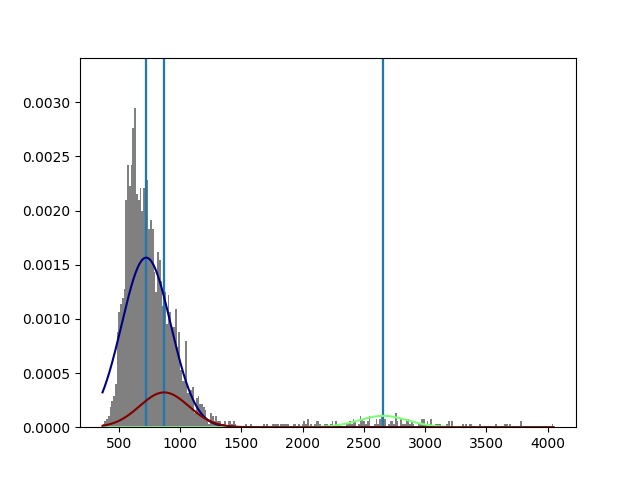

In [107]:
100000
sss.post_cs_pause_time = 0.000
sss.recluster_complex_spikes(gmm_nc=3, plot_hist=True)


In [119]:
cs_indices = sss.get_cs_spike_indices()

detected_tol_pos = 0.001
detected_tol_neg = 0.001

dtp = detected_tol_pos/sss.dt
dtn = detected_tol_neg/sss.dt

from kaveh.toolbox import closest_argmin
cs = closest_argmin(cs_indices, cs_spiketrain)
# plt.figure();
# plt.plot(cs_spiketrain[cs] - cs_indices)
cs = closest_argmin(cs_indices, cs_spiketrain)
false_positive_rate = np.count_nonzero(np.where(np.logical_or(cs_spiketrain[cs] - cs_indices > dtp, cs_spiketrain[cs] - cs_indices < -dtn )))

false_positive_rate = float(false_positive_rate)/cs_indices.size

print('False positive rate = {}'.format(false_positive_rate))

cs = closest_argmin(cs_spiketrain[cs_spiketrain < range_end], cs_indices)
false_negative_rate = np.count_nonzero(np.where(np.logical_or(cs_indices[cs] - cs_spiketrain[cs_spiketrain < range_end] > dtp, cs_indices[cs] - cs_spiketrain[cs_spiketrain < range_end] < -dtn )))
# plt.figure();
# plt.plot(cs_indices[cs] - cs_spiketrain)

false_negative_rate = float(false_negative_rate)/np.count_nonzero(cs_spiketrain < range_end)

print('False negative rate = {}'.format(false_negative_rate))


False positive rate = 0.914285714286
False negative rate = 0.8


In [86]:
np.count_nonzero(cs_spiketrain < range_end)

903

<IPython.core.display.Javascript object>


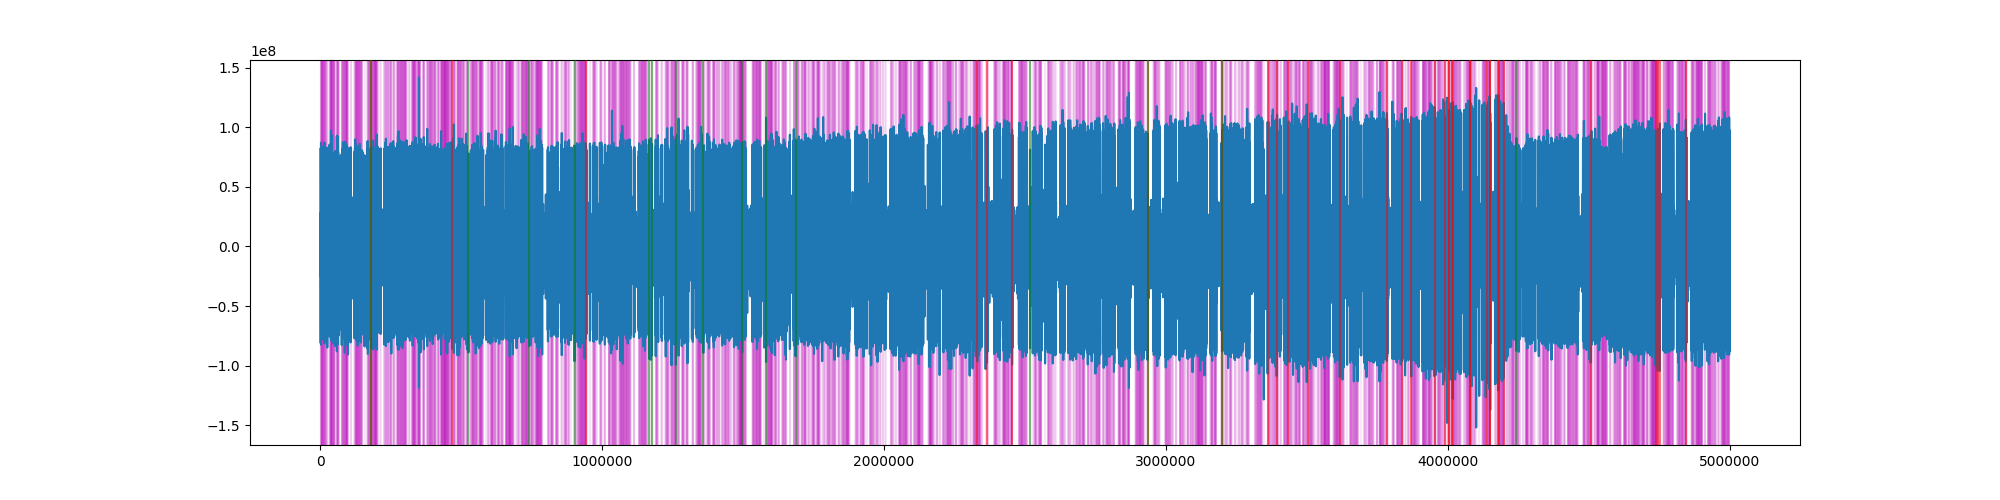

In [120]:
plt.close('all')
plt.figure(figsize=(20,5))
plt.plot(sss.voltage_filtered)

axvlines(plt.gca(), sss.get_spike_indices(), color = 'm', alpha = 0.1)
axvlines(plt.gca(), cs_indices, color = 'r', alpha = 0.5, zorder=10)
axvlines(plt.gca(), cs_spiketrain[cs_spiketrain < range_end] , color = 'g', alpha = 0.5, zorder=11)

<IPython.core.display.Javascript object>


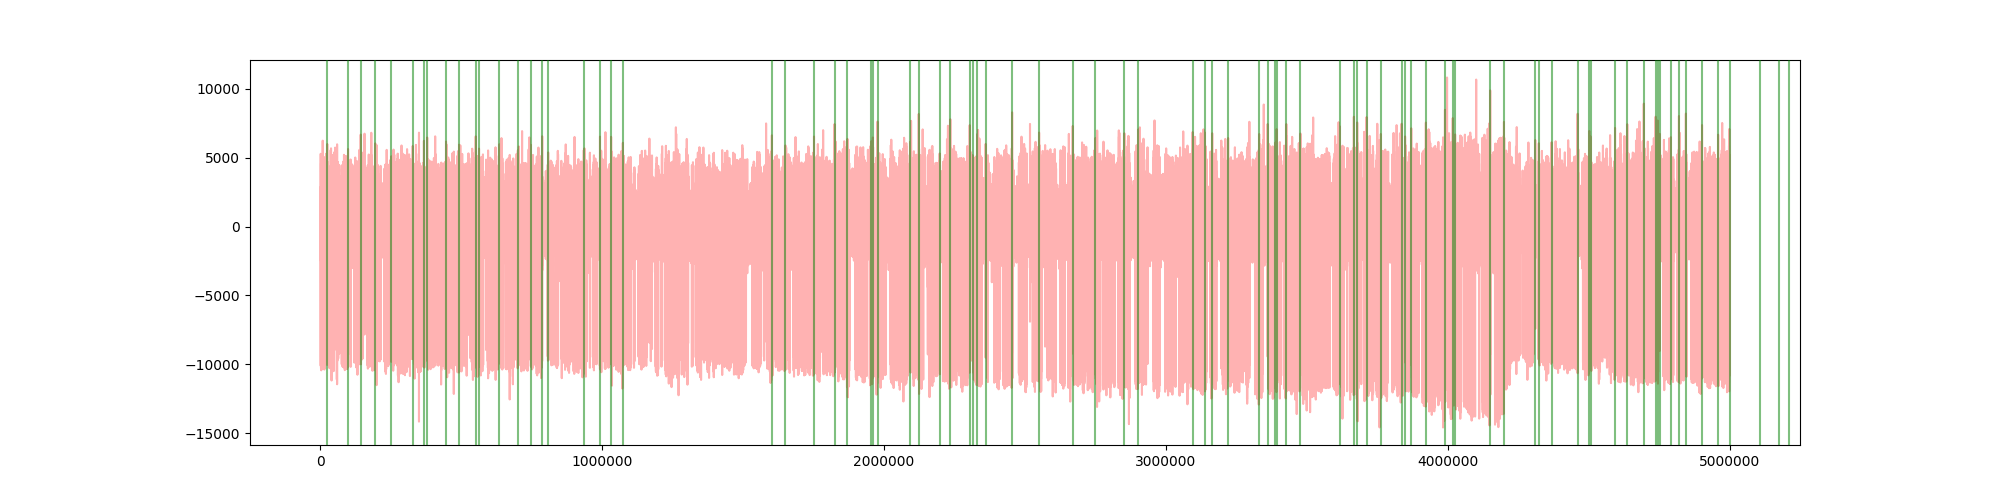

In [57]:
sss = SimpleSpikeSorter(voltage_chan.data[0:range_end], voltage_chan.dt)
# sss.freq_range = (1, 100)
sss.low_pass_filter_cutoff = 10000
sss.high_pass_filter_cutoff = 1000
sss._pre_process();

plt.close('all')
plt.figure(figsize=(20,5))
# plt.plot(sss.voltage_filtered)
plt.plot(sss.voltage, 'r', alpha=0.3)

axvlines(plt.gca(), cs_spiketrain, color = 'g', alpha = 0.5, zorder=11)

In [ ]:
plt.figure()
plt.plot(np.diff(cs_indices)*sss.dt, '.r')
print(np.min(np.diff(cs_indices)*sss.dt))

In [ ]:
import scipy.signal
import scipy.fftpack
from scipy.stats import norm

powers = [] 
max_powers = []
for wf in sss.aligned_spikes:
    yf = scipy.fftpack.fft(wf)
    N = wf.size
    xf = np.linspace(0.0, 1.0 / (2.0 * sss.dt), N/2)
    mask = (xf < sss.freq_range[1]) & (xf >= sss.freq_range[0])
    power_spectrum = 2.0/N * np.abs(yf[:N//2])
    max_powers = max_powers + [np.max(power_spectrum[mask])]
    powers.append(power_spectrum[mask])

In [ ]:

plt.figure()
plt.plot(powers[1])
np.sum(powers[1])- np.min(powers[1])

In [2]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
with open('sweep-pca-regFactor.pkl', 'rb') as input:
    results = pickle.load(input)

In [6]:

results['1010'].cv_results_['split0_test_score']

array([0.95081967, 0.95745511, 0.96370023, 0.96330991, 0.96330991,
       0.96291959, 0.96291959, 0.96291959])